In [47]:
from gensim.models import KeyedVectors

input_file = './util/glove.6B.100d.txt'
model_glove = KeyedVectors.load_word2vec_format(input_file,
                                                binary=False,
                                                no_header=True)

In [48]:
from gensim.models import KeyedVectors

# Load the model
filename = './util/GoogleNews-vectors-negative300.bin'
model_wv = KeyedVectors.load_word2vec_format(filename, binary=True)

In [49]:
import fasttext
model_ft = fasttext.load_model('./util/cc.en.300.bin')

In [50]:
all_models = [model_glove, model_ft, model_wv]
model_names = ['glove', 'fasttext', 'word2vec']

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

In [53]:
import util.normalization as norm
import util.model as models
import util.utility as util

In [54]:
df = pd.read_csv("./sample-mcd.csv", encoding='latin1')
df = df[['reviewer_id', 'review_time', 'review', 'rating']]
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   reviewer_id  100 non-null    int64 
 1   review_time  100 non-null    object
 2   review       100 non-null    object
 3   rating       100 non-null    object
dtypes: int64(1), object(3)
memory usage: 3.3+ KB
None


,reviewer_id,review_time,review,rating
0,1,3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,a month ago,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,5 stars
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


# Normalization

In [55]:
# Tokenization into sentence

df_st = df[['reviewer_id', 'review']].copy()

# Sentence Tokenization
df_st['token_sentence'] = df_st['review'].apply(norm.sentence_tokenize)
df_st = df_st.explode('token_sentence')
df_st['token_sentence'] = df_st['token_sentence'].str.strip()

# Remove non-ASCII
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.remove_non_ascii)

# Expand contractions
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.expand_contractions)

# Remove characters
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.remove_characters, args=(True,))

# Remove enter tab
df_st['token_clean'] = df_st['token_sentence'].apply(norm.remove_enter_tab)

# Lemmatization
df_st['token_clean'] = df_st['token_clean'].apply(norm.lemmatize_text)

# Get Aspect

In [56]:
# Get aspect from rules
tqdm.pandas()
df_st['sub_aspect'] = df_st['token_clean']\
                        .progress_apply(util.get_aspect_rules)

100%|████████████████████████████████████████████████████████████████████████████████| 546/546 [00:25<00:00, 21.58it/s]


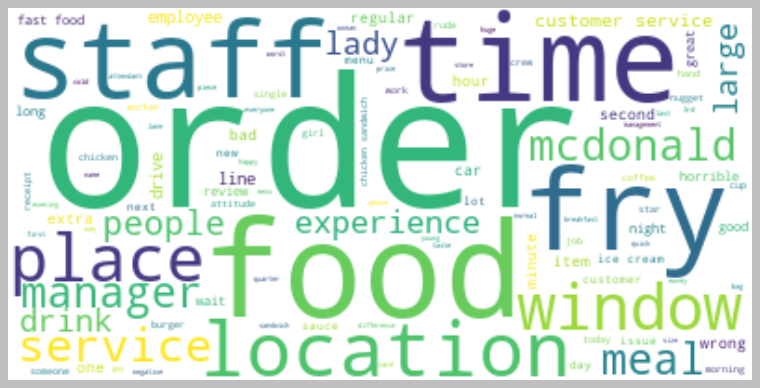

In [81]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ""
sub_aspect = df_st['sub_aspect'].values
for i in range(df_st.shape[0]):
    text = text + " " + " ".join(list(sub_aspect[i]))
    

text = text.strip()

wordcloud = WordCloud(background_color='white').generate(text)
plt.style.use('classic')
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [65]:
aspects = ['food', 'service', 'order', ]

def fun1(x, model):
    temp = set()
    for e in x:
        aspect = util.get_nearest_word(e, aspects, model)
        if aspect:
            temp.add(aspect)
    temp = list(temp)
    return temp

for model, name in zip(all_models, model_names):
    tqdm.pandas()
    df_st[f'aspect_{name}'] = df_st['sub_aspect'].progress_apply(fun1, args=(model,))
df_st

100%|██████████████████████████████████████████████████████████████████████████████| 546/546 [00:00<00:00, 5095.58it/s]


,reviewer_id,review,token_sentence,token_clean,sub_aspect,aspect_glove,aspect_fasttext,aspect_word2vec,pattern_prediction,roberta_prediction
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food,why do it look like someone spit on my food,{someone spit},[order],[food],[food],negative,negative
0,1,Why does it look like someone spit on my food?...,I had a normal transaction,i have a normal transaction,{normal transaction},[order],[order],[service],positive,positive
0,1,Why does it look like someone spit on my food?...,everyone was chill and polite,everyone be chill and polite,{everyone},[order],[food],[food],negative,positive
0,1,Why does it look like someone spit on my food?...,but now i dont want to eat this.,but now i dont want to eat this .,{},[],[],[],negative,negative
0,1,Why does it look like someone spit on my food?...,Im trying not to think about what this milky w...,im try not to think about what this milky whit...,{clear substance},[order],[order],[food],negative,positive
...,...,...,...,...,...,...,...,...,...,...
98,99,Allways has the best Fries and Ice cream in th...,Allways has the best Fries and Ice cream in th...,allways have the best fry and ice cream in the...,"{ice cream, allways, best fry}",[food],"[food, service]","[food, service]",positive,positive
99,100,Mcdonalds is great but they really need to hir...,Mcdonalds is great,mcdonalds be great,{mcdonalds},[food],[food],[food],positive,positive
99,100,Mcdonalds is great but they really need to hir...,they really need to hire people who understand...,they really need to hire people who understand...,"{english order, spanish speaker, people}","[food, order]","[food, order]","[food, order]",negative,positive
99,100,Mcdonalds is great but they really need to hir...,The people are really nice,the people be really nice,{people},[food],[food],[food],positive,positive


In [66]:
df_st['aspect_glove'].value_counts()

[]                        142
[order]                   138
[food]                     91
[service]                  60
[order, service]           48
[food, order]              40
[food, order, service]     14
[food, service]            13
Name: aspect_glove, dtype: int64

# Sentiment Analysis

In [67]:
tqdm.pandas()
df_st['pattern_prediction'] = df_st['token_clean']\
                    .progress_apply(models.pattern_lexicon_model)

100%|██████████████████████████████████████████████████████████████████████████████| 546/546 [00:00<00:00, 6635.10it/s]


In [68]:
tqdm.pandas()
df_st['roberta_prediction'] = df_st['token_sentence']\
                        .progress_apply(models.roberta_model)

100%|████████████████████████████████████████████████████████████████████████████████| 546/546 [08:50<00:00,  1.03it/s]


# Get Result

In [69]:
def get_result(aspect, model, emb_name):
    
    # Initialization
    get_aspects = df_st[f'aspect_{emb_name}'].values
    get_predictions = df_st[model].values
    
    temp = []

    for i in range(len(get_aspects)):
        if (not get_aspects[i]) or (aspect not in get_aspects[i]):
            temp.append(0)
        else:
            if get_predictions[i] == 'negative':
                temp.append(-99)
            else:
                temp.append(1)
    return np.array(temp)

In [72]:

get_pattern = df_st['pattern_prediction'].values
get_roberta = df_st['roberta_prediction'].values

new_fields = set()
for name in model_names:
    for aspect in aspects:

        df_st[aspect + f"_pattern_{name}"] = get_result(aspect, 'pattern_prediction', name)
        df_st[aspect + f"_roberta_{name}"] = get_result(aspect, 'roberta_prediction', name)
        new_fields.add(aspect + f"_pattern_{name}")
        new_fields.add(aspect + f"_roberta_{name}")

new_fields = list(new_fields)
print(df_st.info())
df_st

<class 'pandas.core.frame.DataFrame'>
Int64Index: 546 entries, 0 to 99
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   reviewer_id               546 non-null    int64 
 1   review                    546 non-null    object
 2   token_sentence            546 non-null    object
 3   token_clean               546 non-null    object
 4   sub_aspect                546 non-null    object
 5   aspect_glove              546 non-null    object
 6   aspect_fasttext           546 non-null    object
 7   aspect_word2vec           546 non-null    object
 8   pattern_prediction        546 non-null    object
 9   roberta_prediction        546 non-null    object
 10  food_pattern              546 non-null    int32 
 11  food_roberta              546 non-null    int32 
 12  service_pattern           546 non-null    int32 
 13  service_roberta           546 non-null    int32 
 14  order_pattern             5

,reviewer_id,review,token_sentence,token_clean,sub_aspect,aspect_glove,aspect_fasttext,aspect_word2vec,pattern_prediction,roberta_prediction,...,service_pattern_fasttext,service_roberta_fasttext,order_pattern_fasttext,order_roberta_fasttext,food_pattern_word2vec,food_roberta_word2vec,service_pattern_word2vec,service_roberta_word2vec,order_pattern_word2vec,order_roberta_word2vec
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food,why do it look like someone spit on my food,{someone spit},[order],[food],[food],negative,negative,...,0,0,0,0,-99,-99,0,0,0,0
0,1,Why does it look like someone spit on my food?...,I had a normal transaction,i have a normal transaction,{normal transaction},[order],[order],[service],positive,positive,...,0,0,1,1,0,0,1,1,0,0
0,1,Why does it look like someone spit on my food?...,everyone was chill and polite,everyone be chill and polite,{everyone},[order],[food],[food],negative,positive,...,0,0,0,0,-99,1,0,0,0,0
0,1,Why does it look like someone spit on my food?...,but now i dont want to eat this.,but now i dont want to eat this .,{},[],[],[],negative,negative,...,0,0,0,0,0,0,0,0,0,0
0,1,Why does it look like someone spit on my food?...,Im trying not to think about what this milky w...,im try not to think about what this milky whit...,{clear substance},[order],[order],[food],negative,positive,...,0,0,-99,1,-99,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,99,Allways has the best Fries and Ice cream in th...,Allways has the best Fries and Ice cream in th...,allways have the best fry and ice cream in the...,"{ice cream, allways, best fry}",[food],"[food, service]","[food, service]",positive,positive,...,1,1,0,0,1,1,1,1,0,0
99,100,Mcdonalds is great but they really need to hir...,Mcdonalds is great,mcdonalds be great,{mcdonalds},[food],[food],[food],positive,positive,...,0,0,0,0,1,1,0,0,0,0
99,100,Mcdonalds is great but they really need to hir...,they really need to hire people who understand...,they really need to hire people who understand...,"{english order, spanish speaker, people}","[food, order]","[food, order]","[food, order]",negative,positive,...,0,0,-99,1,-99,1,0,0,-99,1
99,100,Mcdonalds is great but they really need to hir...,The people are really nice,the people be really nice,{people},[food],[food],[food],positive,positive,...,0,0,0,0,1,1,0,0,0,0


In [73]:
grouped_df = df_st[ ['reviewer_id'] + new_fields ].groupby('reviewer_id').sum()

grouped_df = grouped_df.applymap(lambda x: 0 if x < 0 else 1).reset_index()

grouped_df

,reviewer_id,food_roberta_glove,service_pattern_word2vec,service_pattern_glove,order_roberta_glove,order_roberta_fasttext,food_pattern_word2vec,order_pattern_word2vec,food_pattern_fasttext,order_roberta_word2vec,service_roberta_glove,service_roberta_fasttext,food_roberta_word2vec,service_roberta_word2vec,service_pattern_fasttext,food_pattern_glove,food_roberta_fasttext,order_pattern_glove,order_pattern_fasttext
0,1,1,1,1,0,1,0,1,0,1,1,1,0,1,1,1,0,0,0
1,2,1,0,0,1,1,0,1,1,1,1,1,1,1,0,1,1,0,0
2,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,4,1,0,0,1,1,0,1,0,1,1,1,1,1,0,0,1,1,1
4,5,1,0,1,0,1,0,0,0,1,1,1,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
96,97,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
97,98,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0
98,99,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [74]:
result = df.merge(grouped_df, on='reviewer_id', how='left')

print(result.info())
result.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   reviewer_id               100 non-null    int64 
 1   review_time               100 non-null    object
 2   review                    100 non-null    object
 3   rating                    100 non-null    object
 4   food_roberta_glove        100 non-null    int64 
 5   service_pattern_word2vec  100 non-null    int64 
 6   service_pattern_glove     100 non-null    int64 
 7   order_roberta_glove       100 non-null    int64 
 8   order_roberta_fasttext    100 non-null    int64 
 9   food_pattern_word2vec     100 non-null    int64 
 10  order_pattern_word2vec    100 non-null    int64 
 11  food_pattern_fasttext     100 non-null    int64 
 12  order_roberta_word2vec    100 non-null    int64 
 13  service_roberta_glove     100 non-null    int64 
 14  service_roberta_fasttext  1

,reviewer_id,review_time,review,rating,food_roberta_glove,service_pattern_word2vec,service_pattern_glove,order_roberta_glove,order_roberta_fasttext,food_pattern_word2vec,...,order_roberta_word2vec,service_roberta_glove,service_roberta_fasttext,food_roberta_word2vec,service_roberta_word2vec,service_pattern_fasttext,food_pattern_glove,food_roberta_fasttext,order_pattern_glove,order_pattern_fasttext
0,1,3 months ago,Why does it look like someone spit on my food?...,1 star,1,1,1,0,1,0,...,1,1,1,0,1,1,1,0,0,0
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars,1,0,0,1,1,0,...,1,1,1,1,1,0,1,1,0,0
2,3,5 days ago,Made a mobile order got to the speaker and che...,1 star,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,4,a month ago,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,5 stars,1,0,0,1,1,0,...,1,1,1,1,1,0,0,1,1,1
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star,1,0,1,0,1,0,...,1,1,1,1,0,1,1,0,0,0


# Evaluation

In [75]:
df_val = pd.read_csv('validation-mcd.csv')

print(df_val.info())
df_val.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   reviewer_id  100 non-null    int64 
 1   review_time  100 non-null    object
 2   review       100 non-null    object
 3   rating       100 non-null    object
 4   food         100 non-null    object
 5   service      100 non-null    object
 6   order        100 non-null    object
 7   place        100 non-null    object
dtypes: int64(1), object(7)
memory usage: 6.4+ KB
None


,reviewer_id,review_time,review,rating,food,service,order,place
0,1,3 months ago,Why does it look like someone spit on my food?...,1 star,Negative,Neutral,Positive,Negative
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars,Positive,Positive,Neutral,Positive
2,3,5 days ago,Made a mobile order got to the speaker and che...,1 star,Neutral,Negative,Negative,Neutral
3,4,a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars,Positive,Positive,Neutral,Neutral
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star,Negative,Negative,Negative,Negative


In [76]:
def mapping_sentiment(x):
    if x == 'Negative':
        return 0
    else:
        return 1    

    
for aspect in aspects:
    df_val[aspect] = df_val[aspect].apply(mapping_sentiment)

print(df_val.info())
df_val.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   reviewer_id  100 non-null    int64 
 1   review_time  100 non-null    object
 2   review       100 non-null    object
 3   rating       100 non-null    object
 4   food         100 non-null    int64 
 5   service      100 non-null    int64 
 6   order        100 non-null    int64 
 7   place        100 non-null    object
dtypes: int64(4), object(4)
memory usage: 6.4+ KB
None


,reviewer_id,review_time,review,rating,food,service,order,place
0,1,3 months ago,Why does it look like someone spit on my food?...,1 star,0,1,1,Negative
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars,1,1,1,Positive
2,3,5 days ago,Made a mobile order got to the speaker and che...,1 star,1,0,0,Neutral
3,4,a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars,1,1,1,Neutral
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star,0,0,0,Negative


In [79]:
from sklearn.metrics import classification_report, roc_auc_score

for name in model_names:
    print(f"Prediction pattern {name}")
    print("==============================================================")
    for aspect in aspects:
        try:
            actual = df_val[aspect]
            pred = result[aspect + f"_pattern_{name}"]
            print(f"ROC AUC Score: ", roc_auc_score(actual, pred))
            print(f"Result {aspect}")
            print(classification_report(actual, pred))
        except:
            continue

Prediction pattern glove
ROC AUC Score:  0.6963534361851332
Result food
              precision    recall  f1-score   support

           0       0.45      0.87      0.59        31
           1       0.90      0.52      0.66        69

    accuracy                           0.63       100
   macro avg       0.68      0.70      0.63       100
weighted avg       0.76      0.63      0.64       100

ROC AUC Score:  0.6307692307692309
Result service
              precision    recall  f1-score   support

           0       0.75      0.66      0.70        65
           1       0.49      0.60      0.54        35

    accuracy                           0.64       100
   macro avg       0.62      0.63      0.62       100
weighted avg       0.66      0.64      0.65       100

ROC AUC Score:  0.6682986536107711
Result order
              precision    recall  f1-score   support

           0       0.68      0.89      0.77        57
           1       0.76      0.44      0.56        43

    accuracy

In [80]:
for name in model_names:
    print(f"Prediction roberta {name}")
    print("==============================================================")
    for aspect in aspects:
        try:
            actual = df_val[aspect]
            pred = result[aspect + f"_roberta_{name}"]
            print(f"ROC AUC Score: ", roc_auc_score(actual, pred))
            print(f"Result {aspect}")
            print(classification_report(actual, pred))
        except:
            continue

Prediction roberta glove
ROC AUC Score:  0.7349228611500701
Result food
              precision    recall  f1-score   support

           0       0.53      0.77      0.63        31
           1       0.87      0.70      0.77        69

    accuracy                           0.72       100
   macro avg       0.70      0.73      0.70       100
weighted avg       0.77      0.72      0.73       100

ROC AUC Score:  0.7428571428571429
Result service
              precision    recall  f1-score   support

           0       0.91      0.60      0.72        65
           1       0.54      0.89      0.67        35

    accuracy                           0.70       100
   macro avg       0.73      0.74      0.70       100
weighted avg       0.78      0.70      0.71       100

ROC AUC Score:  0.7523459812321501
Result order
              precision    recall  f1-score   support

           0       0.78      0.81      0.79        57
           1       0.73      0.70      0.71        43

    accuracy